# **Library Imports**

In [68]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img


# **Loading the data**

In [47]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
!unzip "/content/gdrive/MyDrive/Copy of CNN_assignment.zip" > /dev/null

In [49]:
# Defining the path for train and test images
data_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [50]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# **Dataset Creation**

In [51]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    shuffle =True,
    image_size =(180, 180),
    batch_size = 32
)

Found 2239 files belonging to 9 classes.


In [52]:
class_names = train_ds.class_names

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_test,
    shuffle =True,
    image_size =(180, 180),
    batch_size = 32
)

Found 118 files belonging to 9 classes.


In [54]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

# **Dataset Visualization**

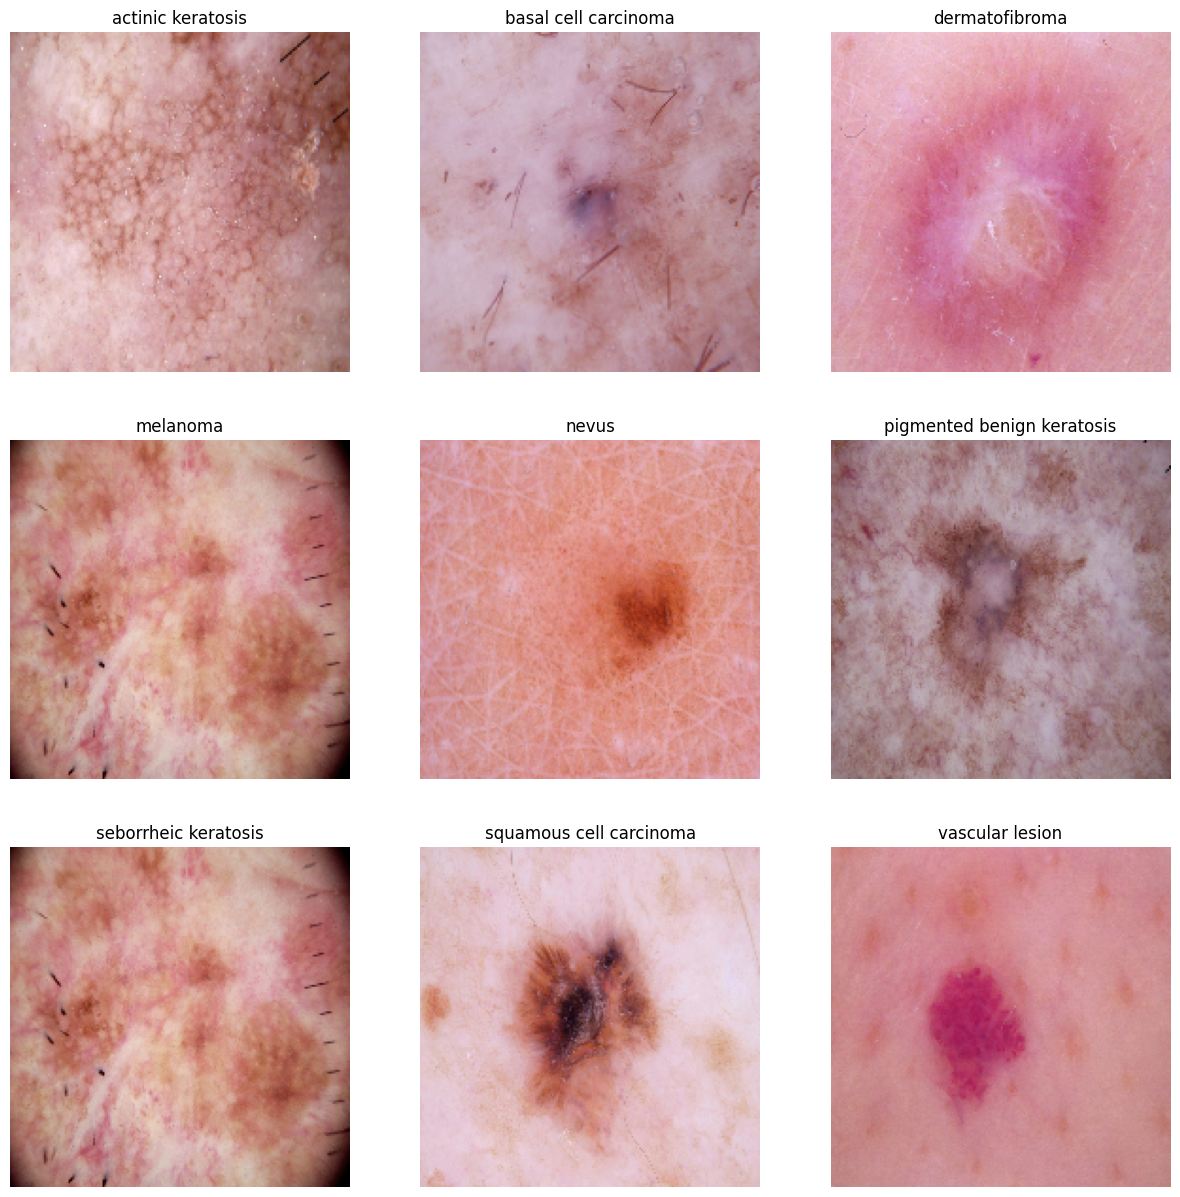

In [55]:
import matplotlib.pyplot as plt

#Dictionary to store the path of image as per the class
files_path_dict = {}

plt.figure(figsize=(15,15))
index = 0
for c in train_ds.class_names:
    files_path_dict[c] = list(map(lambda x:str(data_train)+'/'+c+'/'+x,os.listdir(str(data_train)+'/'+c)))

    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Model building and Training**

In [57]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [58]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_26 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_27 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_28 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_29 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                              

In [59]:
# Compile the model

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_26 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_27 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_28 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_29 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                              

In [61]:
# Model training

epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 26s 138ms/step - loss: -120438.1094 - accuracy: 0.1630 - val_loss: -120096.1719 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 5s 64ms/step - loss: -1384649.6250 - accuracy: 0.1679 - val_loss: -1067407.3750 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 4s 64ms/step - loss: -5108998.0000 - accuracy: 0.1679 - val_loss: -4765723.5000 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 5s 65ms/step - loss: -12787675.0000 - accuracy: 0.1679 - val_loss: -10406055.0000 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 5s 66ms/step - loss: -25676604.0000 - accuracy: 0.1679 - val_loss: -24677026.0000 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 5s 69ms/step - loss: -45345436.0000 - accuracy: 0.1679 - val_loss: -47736860.0000 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 5s 71ms/step

**Vizualize model results**

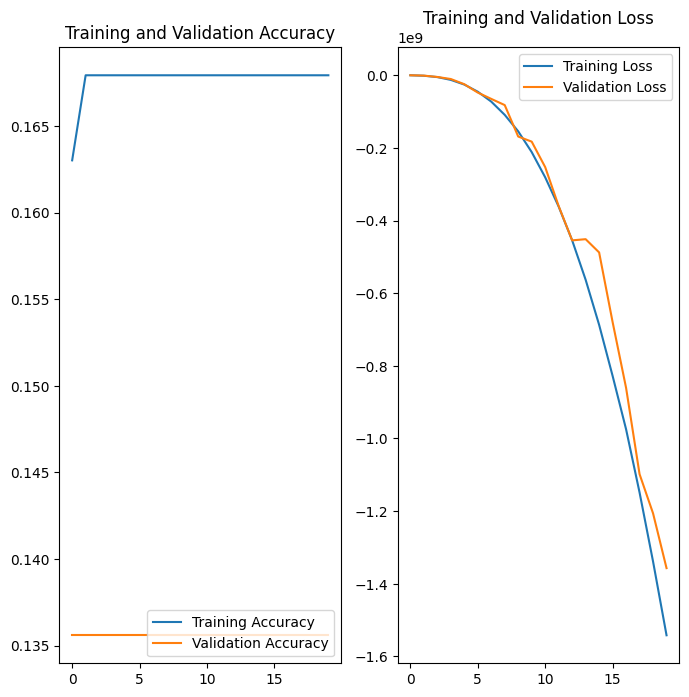

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

4/4 [==============================] - 0s 17ms/step - loss: -1356856320.0000 - accuracy: 0.1356
Accuracy:  0.16793210804462433
Validation Accuracy:  0.1355932205915451
Loss:  -1618657408.0
Validation Loss -1356856320.0


Clearly, model Overfit and right data augumentation strategy needs to be chosen

# **Data Augmentation**

In [64]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(180,
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

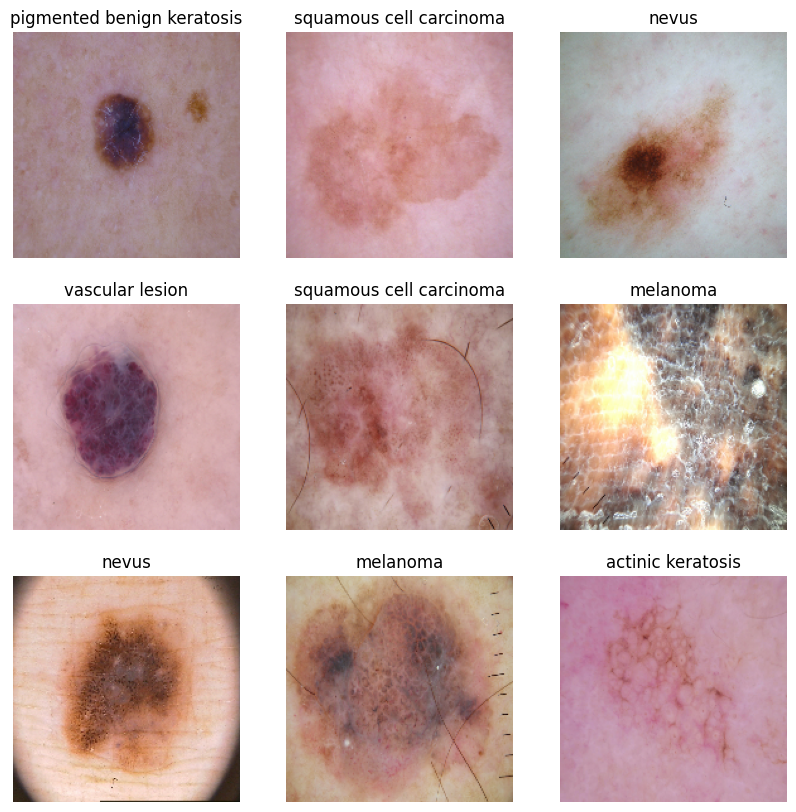

In [65]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Model Rebuild and Train**

In [70]:
model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(16,kernel_size=(3,3),padding='same',activation='relu'))

model.add(MaxPool2D(2,2))

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))

model.add(MaxPool2D(2,2))


model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))


model.add(MaxPool2D(2,2))

model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(128,activation='relu'))

model.add(Dense(len(class_names)))

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.build(input_shape)

# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 module_wrapper_55 (ModuleW  (None, 90, 90, 16)        0         
 rapper)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 module_wrapper_56 (ModuleW  (None, 45, 45, 32)        0         
 rapper)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [72]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 7s 46ms/step - loss: 11.7991 - accuracy: 0.3220 - val_loss: 2.2728 - val_accuracy: 0.2712
Epoch 2/20
70/70 [==============================] - 2s 28ms/step - loss: 1.6563 - accuracy: 0.3979 - val_loss: 3.0509 - val_accuracy: 0.2797
Epoch 3/20
70/70 [==============================] - 2s 29ms/step - loss: 1.5606 - accuracy: 0.4404 - val_loss: 2.4231 - val_accuracy: 0.3475
Epoch 4/20
70/70 [==============================] - 2s 27ms/step - loss: 1.5288 - accuracy: 0.4690 - val_loss: 2.1142 - val_accuracy: 0.2458
Epoch 5/20
70/70 [==============================] - 2s 25ms/step - loss: 1.4969 - accuracy: 0.4757 - val_loss: 2.2189 - val_accuracy: 0.2881
Epoch 6/20
70/70 [==============================] - 2s 25ms/step - loss: 1.3948 - accuracy: 0.5234 - val_loss: 2.2871 - val_accuracy: 0.3305
Epoch 7/20
70/70 [==============================] - 2s 26ms/step - loss: 1.4051 - accuracy: 0.4989 - val_loss: 2.3549 - val_accuracy: 0.3814
Epoch 8/20
7

**Model evaluation**

<built-in method keys of dict object at 0x7be130d96f80> :


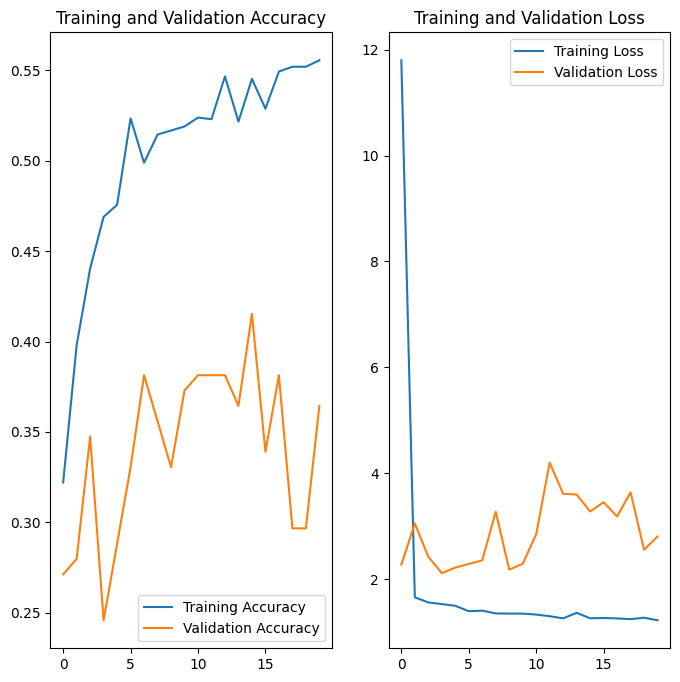

4/4 [==============================] - 0s 10ms/step - loss: 2.8054 - accuracy: 0.3644
Accuracy:  0.5891022682189941
Validation Accuracy:  0.3644067943096161
Loss:  1.1499699354171753
Validation Loss 2.805402994155884


In [73]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)



We have increased accuracies for both training and validation